### Dynamic Bet Size and Limit Prices

Recall the Triple Barrier Labeling technique described in Chapter 3. Barrier $ i $ is formed at time $ t_{i,0} $, when the first barrier is expected to be reached. This prediction implies an expected price $ E_{t_{i,0}}[p_{t_{i,1}}] $, consistent with the barrier setting. During the elapsed period $ t \in [t_{i,0}, t_{i,1}] $ until the outcome is realized, the price $ p_t $ fluctuates, potentially leading to additional predictions $ E_{t_{j,0}}[p_{t_{i,1}}] $, where $ j \in [i + 1, I] $ and $ t_{j,0} \leq t_{i,1} $. 

Previously, we examined how to average active bets and discretize bet sizes in response to new predictions. This section introduces a method to adjust bet sizes dynamically as the market price $ p_t $ and forecast price $ f_i $ evolve, deriving limit prices in the process.

Given $ q_t $ as the current position, $ Q $ as the maximum position size, and $ \hat{q}_{i,t} $ as the target position size associated with the forecast $ f_i $, the following relationship holds:

$
\hat{q}_{i,t} = \text{int}\left[ m [\omega, f_i - p_t]Q\right]
$
$
m[\omega, x] = \frac{x}{\sqrt{\omega + x^2}}
$

Here, $ m[\omega, x] $ represents the bet size, $ x = f_i - p_t $ is the deviation between the current market price and the forecast price, $ \omega $ controls the range of the sigmoid function, and $ \text{int}[x] $ denotes the integer part of $ x $. For the continuous deviation $ x $, where $ -1 < m[\omega, x] < 1 $, the range of $ \hat{q}_{i,t} $ is bounded by $ -Q < \hat{q}_{i,t} < Q $.

The target position size $ \hat{q}_{i,t} $ dynamically adjusts with changes in $ p_t $. Specifically, as $ p_t \rightarrow f_i $, the algorithm aims to realize profits, causing $ \hat{q}_{i,t} \rightarrow 0 $. This implies that the break-even limit price for the order size $ \hat{q}_{i,t} - q_t $ is $ \bar{p} $, calculated as:

$
\bar{p} = \frac{1}{\vert \hat{q}_{i,t} - q_t \vert} \sum_{j = \left\vert q_t + \text{sgn} \left[ \hat{q}_{i,t} - q_t\right] \right\vert}^{\left \vert \hat{q}_{i,t} \right\vert} L \left[ f_i, \omega, \frac{j}{Q}\right]
$

where:

$
L \left[ f_i, \omega, m\right] = f_i - m\sqrt{\frac{\omega}{1 - m^2}}
$

is the inverse function of $ m[\omega, f_i - p_t] $ with respect to $ p_t $. Since $ \vert \hat{q}_{i,t} \vert < 1 $, there is no concern for $ m^2 = 1 $. This function is monotonic, ensuring the algorithm cannot realize losses as $ p_t \rightarrow f_i $.

To determine $ \omega $, we use a user-defined pair $ (x, m^*) $, where $ x = f_i - p_t $ and $ m^* = m[\omega, x] $. The inverse function of $ m[\omega, x] $ with respect to $ \omega $ is:

$
\omega = x^2 (m^{* -2} - 1)
$

The following code implements the algorithm to calculate dynamic position sizes and limit prices as functions of $ p_t $ and $ f_i $. First, it adjusts the sigmoid function to derive a bet size of $ m^* = 0.95 $ for a price deviation of $ x = 10 $. Second, it calculates the target position $ \hat{q}_{i,t} $ for $ Q = 100 $, $ f_i = 115 $, and $ p_t = 100 $, yielding $ \hat{q}_{i,t} = 95 $ for $ f_i = 110 $, consistent with the value of $ \omega $. Third, the break-even limit price for an order size $ \hat{q}_{i,t} - q_t = 97 $ is $ p_t < 112.3657 < f_i $, falling between the current and forecast prices.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

An alternative to the sigmoid function is the power function:

$
\tilde{m}[\omega, x] = \text{sgn}[x] \cdot [x]^{\omega}
$

where $ \omega \geq 0 $, $ x \in [-1, 1] $, and the result $ \tilde{m}[\omega, x] \in [-1, 1] $. This alternative approach has the following advantages:

- $ \tilde{m}[\omega, -1] = -1 $ and $ \tilde{m}[\omega, 1] = 1 $
- The curvature of the function can be directly adjusted using $ \omega $.
- For $ \omega > 1 $, the function transitions from concave to convex, making it nearly flat in the inflection region.

Deriving the formula for the power function is left as an exercise. The following figure illustrates the relationship between bet size and price deviation $ f - p_t $, comparing the sigmoid function with the power function.

In [3]:
def f1(x):
    return np.sign(x) * np.abs(x)**2
def f2(x):
    return x * (0.1 + x**2)**(-0.5)

x_values = np.linspace(-1, 1, 500)
y1_values = f1(x_values)
y2_values = f2(x_values)

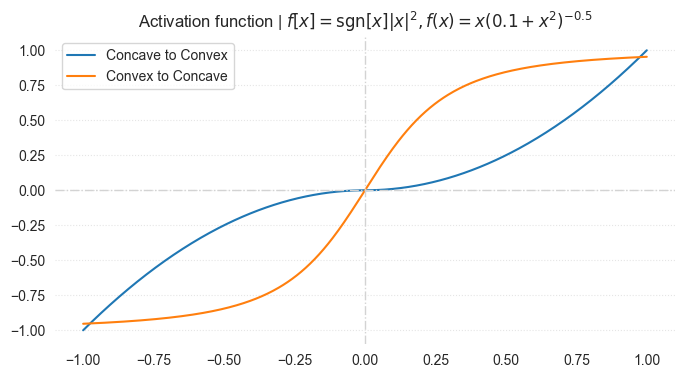

In [9]:
fig, ax = plt.subplots(figsize = (8, 4))
ax.plot(x_values, y1_values, label = 'Concave to Convex')
ax.plot(x_values, y2_values, label = 'Convex to Concave')
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.ylim(-1.1, 1.1)
plt.axvline(x = 0, color = 'lightgray', linestyle = '-.', lw = 1)
plt.axhline(y = 0, color = 'lightgray', linestyle = '-.', lw = 1)
plt.legend()
plt.title(r'Activation function | $f[x] = \text{sgn}[x]|x|^2, f(x) = x(0.1 + x^2)^{-0.5}$')
plt.show()